In [1]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.stats import SigmaClip
from photutils.background import Background2D, SExtractorBackground
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import little_things_functions as ltf
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
from matplotlib import cm
from scipy.fft import fft2, fftshift

(961, 902)


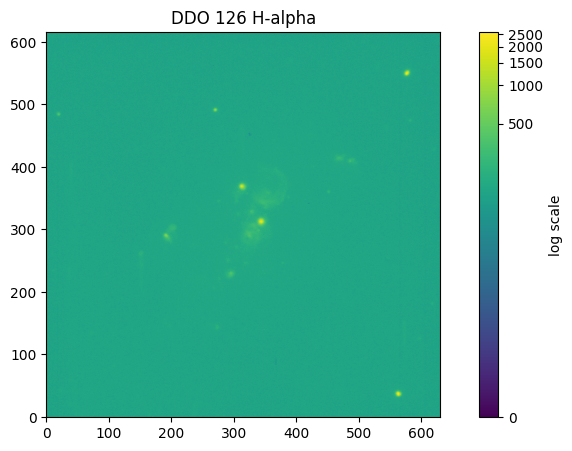

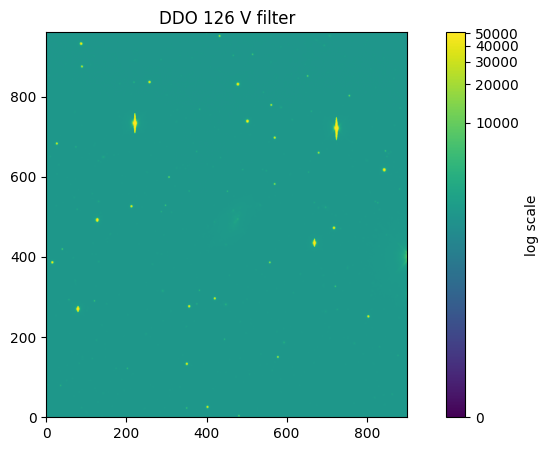

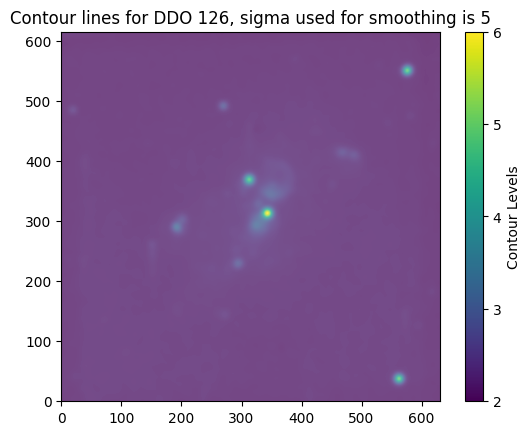

In [2]:
galaxy_name = "DDO 126"
DDO126_H = ltf.open_fits(r"C:\Users\AYSAN\Desktop\project\Galaxy\Data\DDO 126\d126ha.fits")
DDO126_V = ltf.open_fits(r"C:\Users\AYSAN\Desktop\project\Galaxy\Data\DDO 126\d126v.fits")
print(np.shape(DDO126_V))
ltf.log_scale_plot(DDO126_H, "DDO 126 H-alpha", "log scale")
ltf.log_scale_plot(DDO126_V, "DDO 126 V filter", "log scale")

sigma = 5

# Assuming DDO101_H_replaced is already defined
smoothed = gaussian_filter(DDO126_H, sigma)

fig, ax = plt.subplots()
im = ax.imshow(smoothed, alpha=0.75, origin="lower")

# Create the contour plot
levels = [2, 3, 4, 5, 6]
CS = ax.contour(smoothed, levels, cmap='viridis')

# Create a custom color bar for the contour lines
norm = Normalize(vmin=2, vmax=6)  # Adjust this range according to your contour levels
sm = cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

# Add the color bar with labels
cbar = fig.colorbar(sm, ax=ax, ticks=levels)
cbar.ax.set_yticklabels([str(level) for level in levels])
cbar.set_label('Contour Levels')

plt.title(f"Contour lines for {galaxy_name}, sigma used for smoothing is {sigma}")
plt.show()

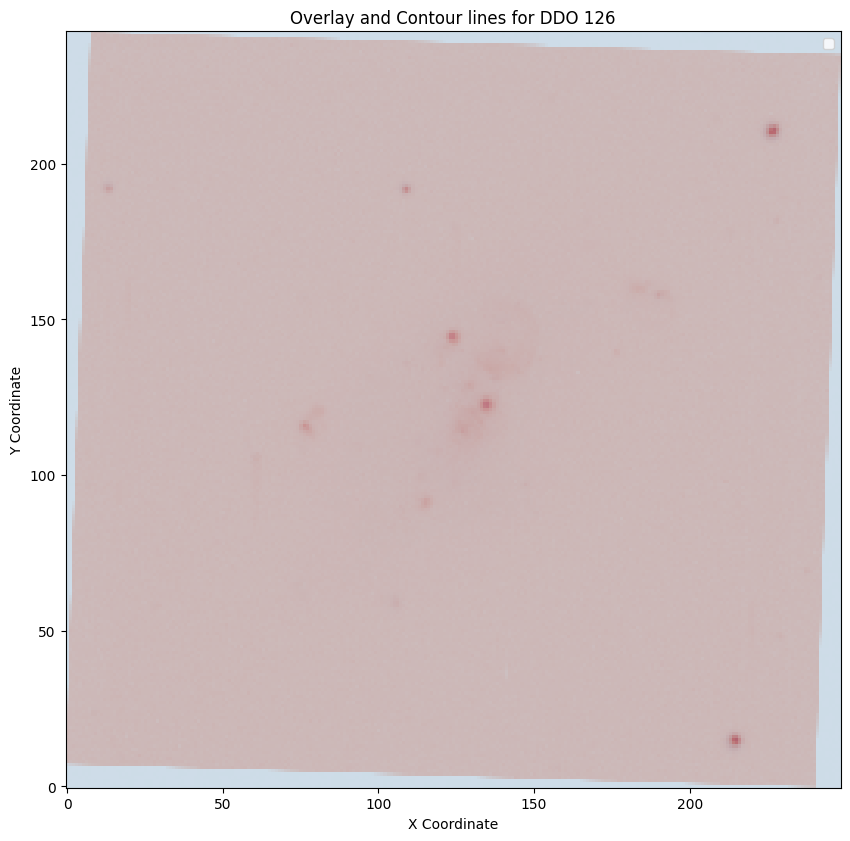

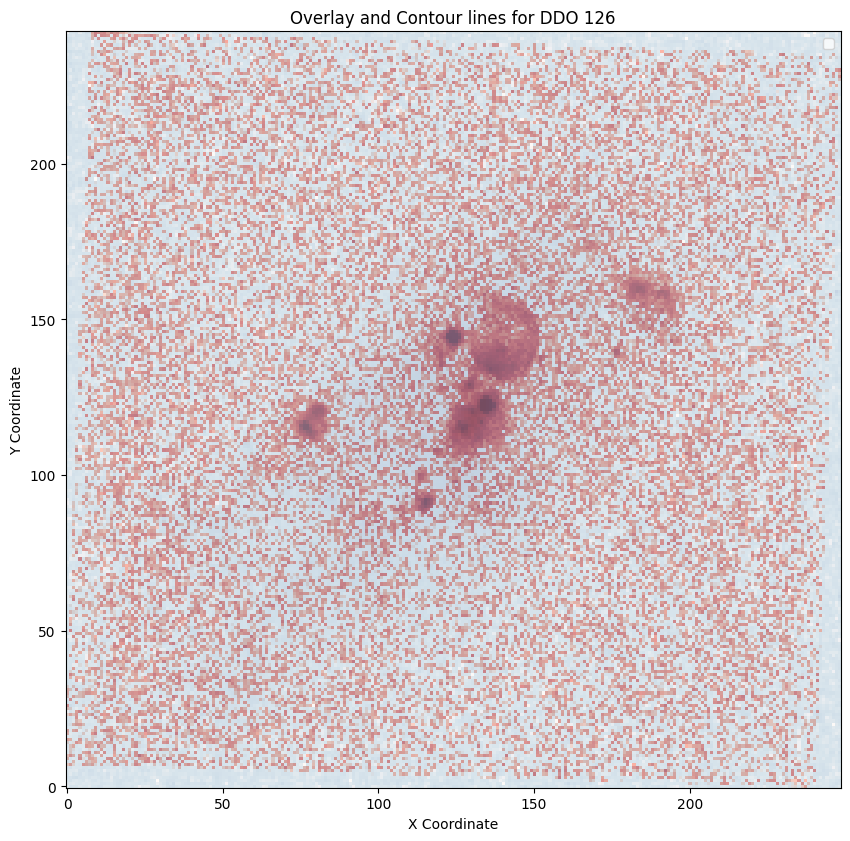

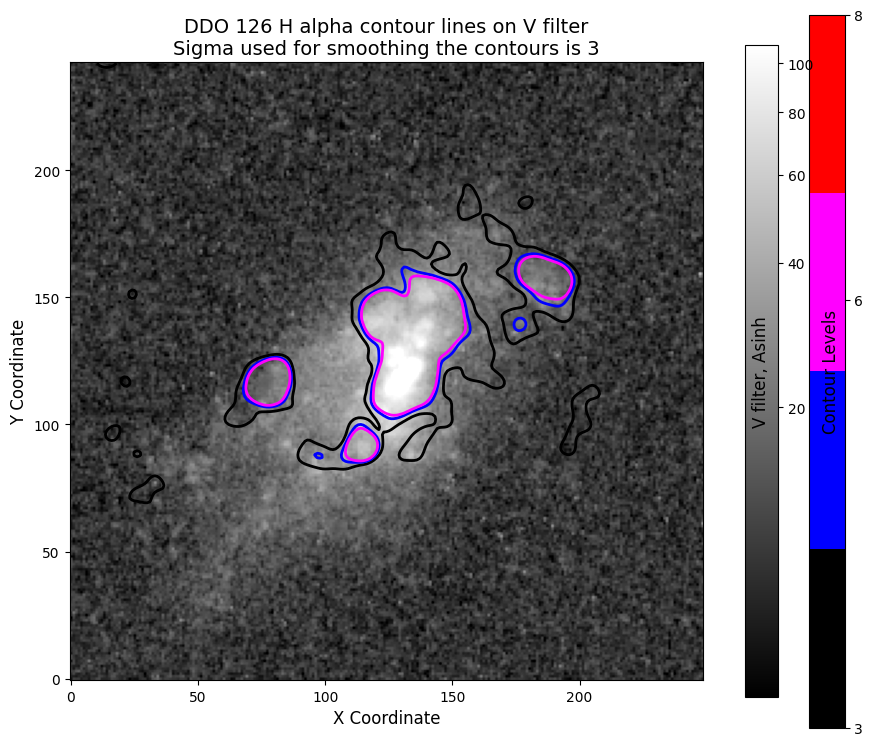

H-alpha pixelscale: 0.43297767223889877


In [3]:
image1_path = r"C:\Users\AYSAN\Desktop\project\Galaxy\Data\DDO 126\d126v.fits"
image2_path = r"C:\Users\AYSAN\Desktop\project\Galaxy\Data\DDO 126\d126ha.fits"
output_dir = r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\d126"
star_coords_V = np.array([[570,582], [452,563], [558,386]])
star_coords_H = np.array([[577,551], [270,492], [563, 37]])

V_with_stars, H_with_stars = ltf.V_and_Halpha_alignment(galaxy_name, image1_path, image2_path, star_coords_V, star_coords_H, output_dir, alpha1=0.5, alpha2=0.5)
image1_path = r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\d126\starless\starless_DDO126_V_background_subtracted.fit"
image2_path = r"C:\Users\AYSAN\Desktop\project\Galaxy\Data\DDO 126\d126hmrms.fits"
V_pixelscale = 1.134
V_image , H_image = ltf.V_and_Halpha_alignment(galaxy_name, image1_path, image2_path, star_coords_V, star_coords_H, output_dir, alpha1=0.5, alpha2=0.5)
ltf.plot_contours_V_and_Halpha(galaxy_name, V_image, H_image, folder_path=r"C:\Users\AYSAN\Desktop\project\Galaxy\H-alpha regions", alpha=1, sigma=3, contour_levels=[3, 6, 8])


H_pixelscale = ltf.calculate_pixelscale(star_coords_V, star_coords_H, V_pixelscale)
print("H-alpha pixelscale:", H_pixelscale)

# Resolution DDO 126

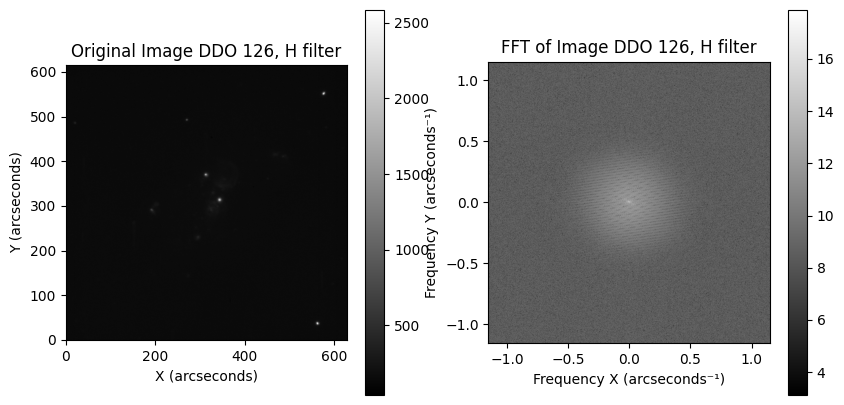

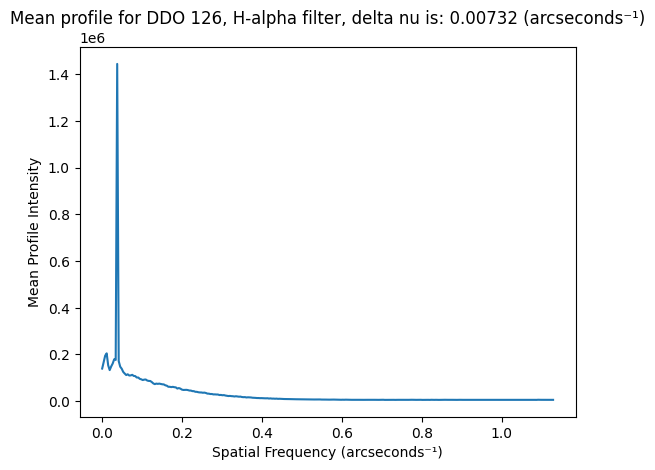

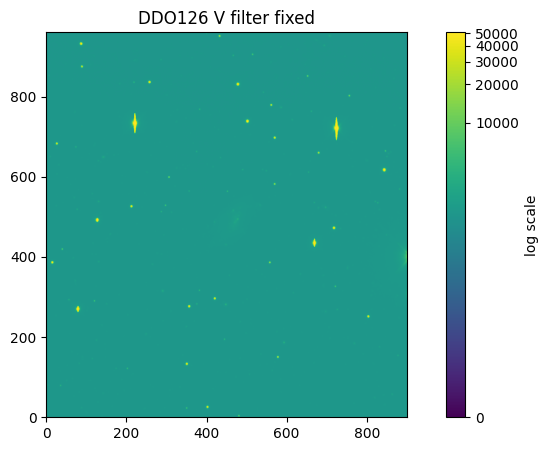

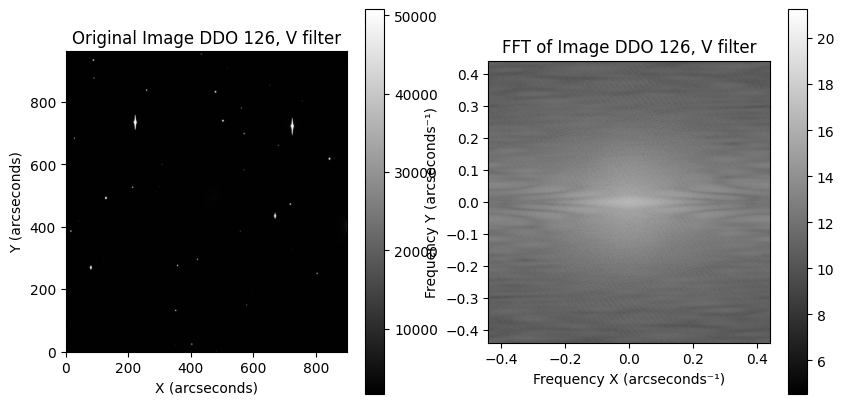

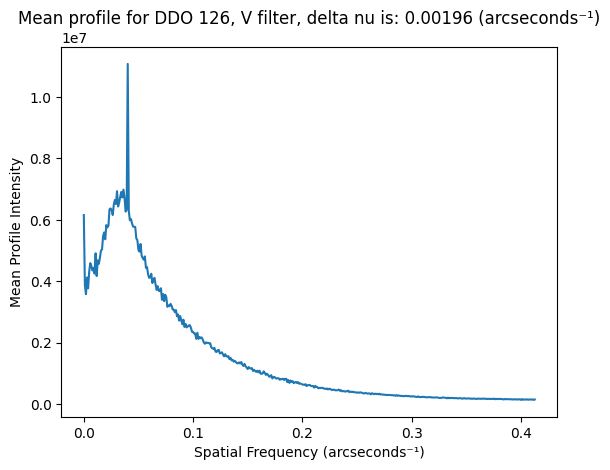

'\nDDO126_V_cropped = DDO126_V[300:600, 300:600]\nltf.log_scale_plot(DDO126_V_cropped, "DDO126 V filter cropped", "log scale")\nprofiles, mean_profile, length = resolution(DDO126_V_cropped, galaxy_name, "V", num_theta=360, pixelscale=V_pixelscale)\nimage_shape = DDO126_V_cropped.shape\nx_ax = np.linspace(0, 1/(2*V_pixelscale), length)\ndela_nu = np.round(2/(image_shape[1]*V_pixelscale), 5)\nplt.plot(x_ax, mean_profile)\nplt.xlabel(\'Spatial Frequency (arcseconds⁻¹)\')\nplt.ylabel(\'Mean Profile Intensity\')\nplt.xlim(0, 0.025) \nplt.title(f\'Mean profile for {galaxy_name}, cropped V filter, delta nu is: {dela_nu} (arcseconds⁻¹)\')\nplt.show()\n'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, fftshift, fftfreq
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize

def compute_fft(image):
    fft_image = fft2(image)
    fft_image_shifted = fftshift(fft_image)
    return fft_image_shifted

def plot_image_and_fft(image, fft_image_shifted, name, filter, pixelscale):
    plt.figure(figsize=(10, 5))
    
    # Original image with axes in arcseconds
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray', origin='lower')
    plt.colorbar()
    plt.xlabel('X (arcseconds)')
    plt.ylabel('Y (arcseconds)')
    plt.title(f'Original Image {name}, {filter} filter')
    
    # FFT of the image with axes in inverse arcseconds
    plt.subplot(1, 2, 2)
    fft_shape = fft_image_shifted.shape
    freq_x = fftshift(fftfreq(fft_shape[1], d=pixelscale))
    freq_y = fftshift(fftfreq(fft_shape[0], d=pixelscale))
    extent = [freq_x.min(), freq_x.max(), freq_y.min(), freq_y.max()]
    plt.imshow(np.log(np.abs(fft_image_shifted)), cmap='gray', origin='lower', extent=extent)
    plt.colorbar()
    plt.xlabel('Frequency X (arcseconds⁻¹)')
    plt.ylabel('Frequency Y (arcseconds⁻¹)')
    plt.title(f'FFT of Image {name}, {filter} filter')
    
    plt.show()

def get_line_profile(image, start_point, angle, length):
    x0, y0 = start_point
    angle_rad = np.deg2rad(angle)
    profile = []

    for r in range(length):
        x = int(x0 + r * np.cos(angle_rad))
        y = int(y0 + r * np.sin(angle_rad))

        if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:
            profile.append(np.abs(image[y, x]))  # Use the magnitude
        else:
            profile.append(np.nan)

    return profile

def resolution(image, name, filter, num_theta, pixelscale):
    fft_image_shifted = compute_fft(image)
    plot_image_and_fft(image, fft_image_shifted, name, filter, pixelscale=pixelscale)
    length = int(np.min(fft_image_shifted.shape) / 2)
    center = np.array(fft_image_shifted.shape) // 2
    profiles = []
    
    for theta in np.linspace(0, 2 * np.pi, num=num_theta, endpoint=False):
        profile = get_line_profile(fft_image_shifted, center, np.rad2deg(theta), length)
        profiles.append(profile)
    
    mean_profile = np.mean(profiles, axis=0)
    
    return profiles, mean_profile, length

def plot_profiles_on_image(image, profiles, num_theta):
    fft_image_shifted = compute_fft(image)
    fft_image_shifted = np.abs(fft_image_shifted)
    norm = ImageNormalize(vmin=0., stretch=LogStretch())
    plt.imshow(fft_image_shifted, cmap='gray', origin='lower', norm = norm)
    center = np.array(fft_image_shifted.shape) // 2
    length = profiles.shape[1]

    for i, theta in enumerate(np.linspace(0, 2 * np.pi, num=num_theta, endpoint=False)):
        x_offset = np.cos(theta)
        y_offset = np.sin(theta)

        x = [center[1] + r * x_offset for r in range(length)]
        y = [center[0] + r * y_offset for r in range(length)]

        plt.plot(x, y, label=f'Theta {np.rad2deg(theta):.1f}°', )

    plt.title('Profiles on Image')
    plt.show()

profiles, mean_profile, length = resolution(DDO126_H, galaxy_name, "H", num_theta=360, pixelscale=H_pixelscale)
image_shape = DDO126_H.shape
x_ax = np.linspace(0, 1/(2*H_pixelscale), length)
dela_nu = np.round(2/(image_shape[1]*H_pixelscale), 5)

plt.plot(x_ax, mean_profile)
plt.xlabel('Spatial Frequency (arcseconds⁻¹)')
plt.ylabel('Mean Profile Intensity')
plt.title(f'Mean profile for {galaxy_name}, H-alpha filter, delta nu is: {dela_nu} (arcseconds⁻¹)')
plt.show()

DDO126_V_trimmed = DDO126_V[140:, 140:760]
# Generate the replacement values from a normal distribution
chunk = DDO126_V_trimmed[100:200, 400:450]
mean = np.mean(chunk)
std_dev = np.std(chunk)
# Create a full array with replacement values
DDO126_V_replaced = np.random.normal(loc=mean, scale=std_dev, size=DDO126_V.shape)

# Copy the trimmed portion back into the original image shape
DDO126_V_replaced[140:, 140:760] = DDO126_V_trimmed
ltf.log_scale_plot(DDO126_V, "DDO126 V filter fixed", "log scale")

profiles, mean_profile, length = resolution(DDO126_V, galaxy_name, "V", num_theta=360, pixelscale=V_pixelscale)

#plot_profiles_on_image(DDO126_V_replaced ,np.array(profiles), num_theta=0 )

image_shape = DDO126_V.shape
x_ax = np.linspace(0, 1/(2*V_pixelscale), length)
dela_nu = np.round(2/(image_shape[1]*V_pixelscale), 5)
plt.plot(x_ax, mean_profile)
plt.xlabel('Spatial Frequency (arcseconds⁻¹)')
plt.ylabel('Mean Profile Intensity')
plt.title(f'Mean profile for {galaxy_name}, V filter, delta nu is: {dela_nu} (arcseconds⁻¹)')
plt.show()
"""
DDO126_V_cropped = DDO126_V[300:600, 300:600]
ltf.log_scale_plot(DDO126_V_cropped, "DDO126 V filter cropped", "log scale")
profiles, mean_profile, length = resolution(DDO126_V_cropped, galaxy_name, "V", num_theta=360, pixelscale=V_pixelscale)
image_shape = DDO126_V_cropped.shape
x_ax = np.linspace(0, 1/(2*V_pixelscale), length)
dela_nu = np.round(2/(image_shape[1]*V_pixelscale), 5)
plt.plot(x_ax, mean_profile)
plt.xlabel('Spatial Frequency (arcseconds⁻¹)')
plt.ylabel('Mean Profile Intensity')
plt.xlim(0, 0.025) 
plt.title(f'Mean profile for {galaxy_name}, cropped V filter, delta nu is: {dela_nu} (arcseconds⁻¹)')
plt.show()
"""